# Data Acquisition

In [1]:
# Import functions
import pandas as pd
import numpy as np
import math
import os
import acquire

import random
random.seed(123)

# Acquire the data

In [ ]:
# Load in primary dataset.
df = pd.read_csv('train.csv', usecols=[1,2,3,4,5,6,7,8,9])

# Training dataset
To reduce the memory size of our training data, we selected a random sample of 100,000 students from `train.csv`.
1. Select 100,000 user ids from `train.csv` to use as our train dataset.
2. Cast numeric column data types using an appropriate precision to reduce memory size.

## Sample training data
- Selecting 100_000 users.

In [ ]:
# Find all users with more than 10 rows.
user_ids = df['user_id'].value_counts()[df['user_id'].value_counts() > 10].index.to_list()

# Select a random sample of 100_000 user_ids.
sampled_ids = random.sample(user_ids, 100_000)

In [ ]:
len(sampled_ids)

In [ ]:
def sampled_users(df):
    '''
    This function accepts data from `train.csv` and
    returns a random sample of 100_000 user_ids.
    '''
    user_ids = df['user_id'].value_counts()[df['user_id'].value_counts() > 10].index.to_list()
    sampled_ids = random.sample(user_ids, 100_000)
    return sampled_ids

In [ ]:
# Using the selected user_ids, filter the dataset for the first 100_000.
filtered_data = pd.DataFrame()

data = df.loc[df['user_id'].isin(sampled_ids)]

In [ ]:
# We have 100_000 users!!!!
data.user_id.nunique()

In [ ]:
# Cache local file for next steps.
# data.to_csv('sampled_train.csv', index=False)

# Dataset loads correctly.
# df = pd.read_csv('sampled_train.csv')

# Casting data types

In [ ]:
def datatype_converter():
    '''
    This function returns a dictionary of column names and data types to convert.
    '''
    
    train_data_types_dict = {
    'timestamp': np.int64,
    'user_id': np.int32,
    'content_id': np.int16,
    'content_type_id': np.int16,
    'task_container_id' : np.int16,
    'user_answer' : np.int8,
    'answered_correctly': np.int8,
    'prior_question_elapsed_time': np.float16
    }
    
    lectures_data_types_dict = {
    'lecture_id' : np.int16,
    'tag' : np.int8,
    'part' : np.int8
    }

    questions_data_types_dict = {
    'question_id' : np.int16,
    'bundle_id' : np.int16,
    'part' : np.int8
    }
    
    
    return train_data_types_dict, lectures_data_types_dict, questions_data_types_dict

In [ ]:
def sampled_train():
    '''
    This function selects a random sample of 100_000 users from the `train.csv` dataset.
    Returns a dataframe of 100_000 users that have more than 10 rows of data.
    
    
    Parameters
    ----------
    None
    
    
    Returns
    -------
    data : pandas.core.frame.DataFrame
        A pandas dataframe of 100,000 randomly selected
        users.
    '''
    train_dtypes, _, _ = datatype_converter()
    
    if os.path.isfile('sampled_train.csv'):
        return pd.read_csv('sampled_train.csv',
                           index_col=False,
                           dtype=train_dtypes)
    else:
        
    # Read in `train.csv` data
        df = pd.read_csv('train.csv', dtype=train_dtypes, usecols=[1,2,3,4,5,6,7,8,9])

        sampled_ids = sampled_users(df)

        sampled_data = df.loc[df['user_id'].isin(sampled_ids)]

        # Cache local file of sampled data.
        sampled_data.to_csv('sampled_train.csv', index=False)
    
    # Return the dataframe
    return sampled_data

Create a function to reproduce the modified training set.

In [ ]:
# Test the function.
df = sampled_train()

In [ ]:
# It works.
df.user_id.value_counts()

In [ ]:
# Check our data types and memory usage.
df.info()

# Merge datasets together

In [ ]:
_, lecture_dtypes, question_dtypes = datatype_converter()

df_lectures = pd.read_csv('lectures.csv', dtype=lecture_dtypes)
df_questions = pd.read_csv('questions.csv', dtype=question_dtypes)

# Left join df_train and df_lectures using `content_id` as the primary key.
df_merged = df.merge(df_lectures, left_on='content_id', right_on='lecture_id', how='left')

# Left join df_merged and df_questions using `content_id` as the primary key.
df_data = df_merged.merge(df_questions, left_on='content_id', right_on='question_id', how='left')

In [ ]:
df_data.info()

In [ ]:
import acquire

In [ ]:
df = acquire.get_riiid_data()

In [ ]:
df.head()

In [ ]:
train = pd.DataFrame()
validate = pd.DataFrame()
test = pd.DataFrame()

# Set up the train size
train_size = 0.8
validate_size = 0.1

sampled_ids = df.user_id.unique()

In [ ]:
for user in sampled_ids:
    data = df.loc[df['user_id'] == user]
    n = data.shape[0]

    train_end_index = int(train_size * n)
    validate_end_index = train_end_index + int(validate_size * n)

    df_train = data.iloc[:train_end_index]
    df_validate = data.iloc[train_end_index:validate_end_index]
    df_test = data.iloc[validate_end_index:]

    train = pd.concat([train, df_train])
    validate = pd.concat([validate, df_validate])
    test = pd.concat([test, df_test])

In [ ]:
# Print the shape of the original, train and test
train.shape, validate.shape, test.shape

In [ ]:
train.to_csv('sampled_trainset.csv', index=False)
validate.to_csv('validate.csv', index=False)
test.to_csv('test.csv', index=False)

In [ ]:
type(train)

# Create a function to split data using Quasi-GroupKFold method
The way our data is currently split for MVP:
- 100,000 randomly selected users that have more that 10 interactions with Riiid's Knowledge tracing application.
- Each user has _sequential_ data, indicated by the variable `timestamp`.
- Data is split using a percentage-based method.
- 0% - 80% of a users data is the training set.
- 80% - 90% of a users data is in the validation set.
- 90% - 100% of a users data is in the test set.

The way we split the data is important. As we currently have our splits, several issues arise that impact our data exploration and modeling performance.
- Spliting the data using a percentage-based method removes questions and lectures from our training data. If a model encounters a question it has never seen before, how can it accurately model reality? We need to have all questions appear at least once in our dataset.
    - If this was _purely_ a time series problem, that would be fine.
- The training set uses 80% of a users data, this impacts our statistical analysis. If we have _all_ of a users data, we can correctly calculate population statistics from a _sample_ of users. We can then compare statistics on a user/grouped level with the population.

What is the solution?

> <strong>Splitting by users!</strong>

## Splitting by users
How does this solve our exploration and modeling issues?
> <strong>By creating users the model has never seen before!</strong>

This simulates _new_ users interacting with Riiid's Knowledge Tracing Application.

In [ ]:
df_data = acquire.get_riiid_data()

In [ ]:
df_data.lecture_id = df_data.lecture_id.astype('Int16')
df_data.tag = df_data.tag.astype('Int8')
df_data.part_x = df_data.part_x.astype('Int8')
df_data.part_y = df_data.part_y.astype('Int8')
df_data.question_id = df_data.question_id.astype('Int16')
df_data.bundle_id = df_data.bundle_id.astype('Int16')
df_data.lecture_id = df_data.lecture_id.astype('Int32')

# Prefix part names with the originating dataframe name.
df_data.rename(columns={'part_x': 'lecture_part',
                        'part_y': 'question_part'},
                   inplace=True)

# Cache the data.
df_data.to_csv('riiid_data.csv', index=False)

### How many users are in the dataset?

In [ ]:
users = df_data.user_id.unique()
print(f'There are {len(users):,} users.')

### Create new data splits using percentage of users

In [ ]:
# Percentages of orginal dataset
train_size = .8
validate_size = .1
test_size = .1

# Calculate the number of users in each dataset.
train_users = int(len(users)*train_size)
validate_users = math.ceil(len(users)*validate_size)
test_users = math.ceil(len(users)*test_size)

# Display the results.
print(f'Train set would contain {train_users:,} users')
print(f'Validate set would contain {validate_users:,} users')
print(f'Test set would contain {test_users:,} users')

In [ ]:
# Check for even splits
print(len(users) == sum([train_users, validate_users, test_users]))

print(len(users))
print(sum([train_users, validate_users, test_users]))

### Test a method to split users into seperate datasets

In [ ]:
# Set a random seed to reproduce splits
random.seed(123)

# Toy example
all_users = [1, 2, 3, 4, 5]

# Randomly select train set users
t_ids = random.sample(all_users, 3)

# Remove users assigned to the training set.
list(set(all_users) - set(t_ids))

### Create a function to reproduce data splits

In [ ]:
def split_users(df, train_size=.8, validate_size=.1, test_size=.1):
    '''
    This function accepts the merged dataframe from acquire.get_riiid_data()
    and returns train, validate and test sets.
    '''
    # Set a random seed to reproduce splits
    random.seed(123)
    
    # Gather all user ids
    user_ids = list(df['user_id'].unique())
    total_num = len(user_ids)
    
    # Calculate the number of users in train, validate, and test.
    train_num = int(total_num*train_size)
    validate_num = math.ceil(total_num*validate_size)
    test_num = math.ceil(total_num*test_size)
    
    # Randomly select 80% of the users to be in train.
    train_ids = random.sample(user_ids, train_num)
    
    # Remove user_ids assigned to the training set.
    remaining_val_test_users = list(set(user_ids) - set(train_ids))
    
    # Assign the remaining user ids to validate and test.
    validate_ids = random.sample(remaining_val_test_users, validate_num)
    test_ids = list(set(remaining_val_test_users) - set(validate_ids))
    
    # Return the users assigned to train, validate, and test
    return train_ids, validate_ids, test_ids

In [ ]:
train_ids, validate_ids, test_ids = split_users(df_data)

In [ ]:
train = df_data.loc[df_data['user_id'].isin(train_ids)]
validate = df_data.loc[df_data['user_id'].isin(validate_ids)]
test = df_data.loc[df_data['user_id'].isin(test_ids)]

In [ ]:
train.to_csv('train_k.csv', index=False)
validate.to_csv('validate_k.csv', index=False)
test.to_csv('test_k.csv', index=False)

In [ ]:
train.info()

### Modify the function to use a subset of the data

In [ ]:
def split_users(df, train_size=.8, validate_size=.1, test_size=.1, sample=True):
    '''
    This function accepts the merged dataframe from acquire.get_riiid_data()
    and returns train, validate and test sets.
    '''
    # Set a random seed to reproduce splits
    random.seed(123)
    
    if sample == True:
        # Gather a random sample of 100_000 user ids
        user_ids = random.sample(list(df['user_id'].unique()), 100_000)
    else:
        # Gather all user ids
        user_ids = list(df['user_id'].unique())
    
    # Calculate the number of users
    total_num = len(user_ids)
    
    # Calculate the number of users in train, validate. Remaining users go in test
    train_num = int(total_num*train_size)
    validate_num = math.ceil(total_num*validate_size)
    
    # Randomly select 80% of the users to be in train.
    train_ids = random.sample(user_ids, train_num)
    
    # Remove user_ids assigned to the training set.
    remaining_val_test_users = list(set(user_ids) - set(train_ids))
    
    # Assign the remaining user ids to validate and test.
    validate_ids = random.sample(remaining_val_test_users, validate_num)
    test_ids = list(set(remaining_val_test_users) - set(validate_ids))
    
    # Return the users assigned to train, validate, and test
    return train_ids, validate_ids, test_ids


def train_validate_test(df, sampled=True):
    '''

    '''
    train_ids, validate_ids, test_ids = split_users(df, sample=sampled)

    train = df.loc[df['user_id'].isin(train_ids)]
    validate = df.loc[df['user_id'].isin(validate_ids)]
    test = df.loc[df['user_id'].isin(test_ids)]

    return train, validate, test

In [ ]:
train, validate, test = train_validate_test(acquire.get_riiid_data())
train.to_csv('mvp_train.csv', index=False)
validate.to_csv('mvp_validate.csv', index=False)
test.to_csv('mvp_test.csv', index=False)

In [ ]:
train.info()

### Modify the function to use a subset of the data: Sample of 50K users

In [ ]:
def split_users(df, train_size=.8, validate_size=.1, sample=True):
    '''
    This function accepts the merged dataframe from acquire.get_riiid_data()
    and returns train, validate and test sets.
    '''
    # Set a random seed to reproduce splits
    random.seed(123)
    
    if sample == True:
        # Gather a random sample of 50_000 user ids
        user_ids = random.sample(list(df['user_id'].unique()), 50_000)
    else:
        # Gather all user ids
        user_ids = list(df['user_id'].unique())
    
    # Calculate the number of users
    total_num = len(user_ids)
    
    # Calculate the number of users in train, validate. Remaining users go in test
    train_num = int(total_num*train_size)
    validate_num = math.ceil(total_num*validate_size)
    
    # Randomly select 80% of the users to be in train.
    train_ids = random.sample(user_ids, train_num)
    
    # Remove user_ids assigned to the training set.
    remaining_val_test_users = list(set(user_ids) - set(train_ids))
    
    # Assign the remaining user ids to validate and test.
    validate_ids = random.sample(remaining_val_test_users, validate_num)
    test_ids = list(set(remaining_val_test_users) - set(validate_ids))
    
    # Return the users assigned to train, validate, and test
    return train_ids, validate_ids, test_ids


def train_validate_test(df, sampled=True):
    '''
    
    '''
    train_ids, validate_ids, test_ids = split_users(df, sample=sampled)

    train = df.loc[df['user_id'].isin(train_ids)]
    validate = df.loc[df['user_id'].isin(validate_ids)]
    test = df.loc[df['user_id'].isin(test_ids)]

    return train, validate, test

In [ ]:
train, validate, test = train_validate_test(acquire.get_riiid_data())

In [ ]:
train.to_csv('mvp_50_train.csv', index=False)
validate.to_csv('mvp_50_validate.csv', index=False)
test.to_csv('mvp_50_test.csv', index=False)

# Exploration

In [1]:
# Import functions
import pandas as pd
import numpy as np
import math
import os
import acquire
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import random
random.seed(123)

Four features I will explore:
1. Running accuracy within a bundle
2. Question Tag Accuracy
3. Tag_#
4. Cumulative user accuracy using Exponentially Weighted Mean

In [2]:
train = pd.read_csv('sampled_trainset.csv')
validate = pd.read_csv('validate.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head()

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,lecture_id,tag,lecture_part,type_of,question_id,bundle_id,correct_answer,question_part,tags
0,0,24600,7900,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,7900.0,7900.0,0.0,1.0,131 93 81
1,25379,24600,7876,0,1,2,0,24000.0,False,NaN,NaN,NaN,NaN,7876.0,7876.0,3.0,1.0,10 94 92
2,50137,24600,175,0,2,2,1,23000.0,False,NaN,NaN,NaN,NaN,175.0,175.0,2.0,1.0,9 10 92
3,70181,24600,1278,0,3,3,1,22000.0,False,NaN,NaN,NaN,NaN,1278.0,1278.0,3.0,2.0,143 140 81 29
4,148601,24600,2064,0,4,2,0,18000.0,False,NaN,NaN,NaN,NaN,2064.0,2063.0,1.0,3.0,157 92 29


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20964878 entries, 0 to 20964877
Data columns (total 18 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   timestamp                       int64  
 1   user_id                         int64  
 2   content_id                      int64  
 3   content_type_id                 int64  
 4   task_container_id               int64  
 5   user_answer                     int64  
 6   answered_correctly              int64  
 7   prior_question_elapsed_time     float64
 8   prior_question_had_explanation  object 
 9   lecture_id                      float64
 10  tag                             float64
 11  lecture_part                    float64
 12  type_of                         object 
 13  question_id                     float64
 14  bundle_id                       float64
 15  correct_answer                  float64
 16  question_part                   float64
 17  tags                     

In [5]:
# Remove lectures rows from the training set.
train = train.loc[(train.answered_correctly != -1)]

## Part Analysis

Part1<br>
Photographs: 6 questions
>Four short statements regarding a photograph will be spoken only one time. The statements will not be printed. Of these four statements, select the one that best describes the photograph and mark your answer on the answer sheet.

Part2<br>
Question-Response: 25 questions
>Three responses to one question or statement will be spoken only one time. They will not be printed. Select the best response for the question, and mark your answer on the answer sheet.

Part3<br>
Conversations: 39 questions
>Conversations between two or three people will be spoken only one time. They will not be printed. Listen to each conversation and read the questions printed in the test book (the questions will also be spoken), select the best response for the question, and mark your answer on the answer sheet. Some questions may require responses related to information found in diagrams,etc. printed on the test book as well as what you heard in the conversations. There are three questions for each conversation.

Part4<br>
Talks: 30 questions
>Short talks such as announcements or narrations will be spoken only one time. They will not be printed. Listen to each talk and read the questions printed in the test book (the questions will also be spoken), select the best response for the question, and mark your answer on the answer sheet. Some questions may require responses related to information found in diagrams, etc. printed on the test book as well as what you heard in the talks. There are three questions for each talk.

Reading Section (75 minutes, 100 questions): Read printed questions and answer them.<br>
Part5<br>
Incomplete Sentences: 30 questions
> Select the best answer of the four choices to complete the sentence, and mark your answer on the answer sheet.

Part6<br>
Text Completion: 16 questions
>Select the best answer of the four choices (words, phrases, or a sentence) to complete the text, and mark your answer on the answer sheet. There are four questions for each text.

Part7<br>
Single Passages: 29 questions
Multiple Passages: 25 questions
> A range of different texts will be printed in the test book. Read the questions, select the best answer of the four choices, and mark your answer on the answer sheet. Some questions may require you to select the best place to insert a sentence within a text. There are multiple questions for each text. 

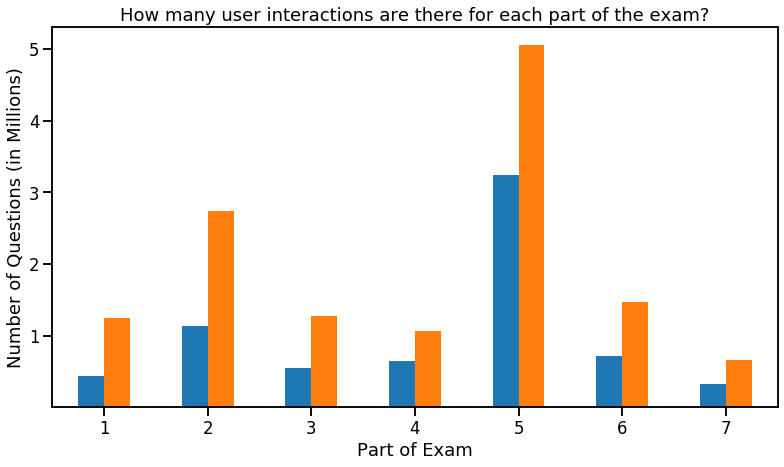

In [6]:
sns.set_context('talk')

pd.crosstab(train.question_part, train.answered_correctly).plot.bar(figsize=(13, 7))

plt.legend().set_visible(False)
plt.title('How many user interactions are there for each part of the exam?')
plt.xlabel('Part of Exam')
plt.ylabel('Number of Questions (in Millions)')
plt.xticks(np.arange(0, 7), labels=['1', '2', '3', '4', '5', '6', '7'], rotation=0)
plt.yticks([1_000_000, 2_000_000, 3_000_000, 4_000_000, 5_000_000], labels=['1', '2', '3', '4', '5'], rotation=0);

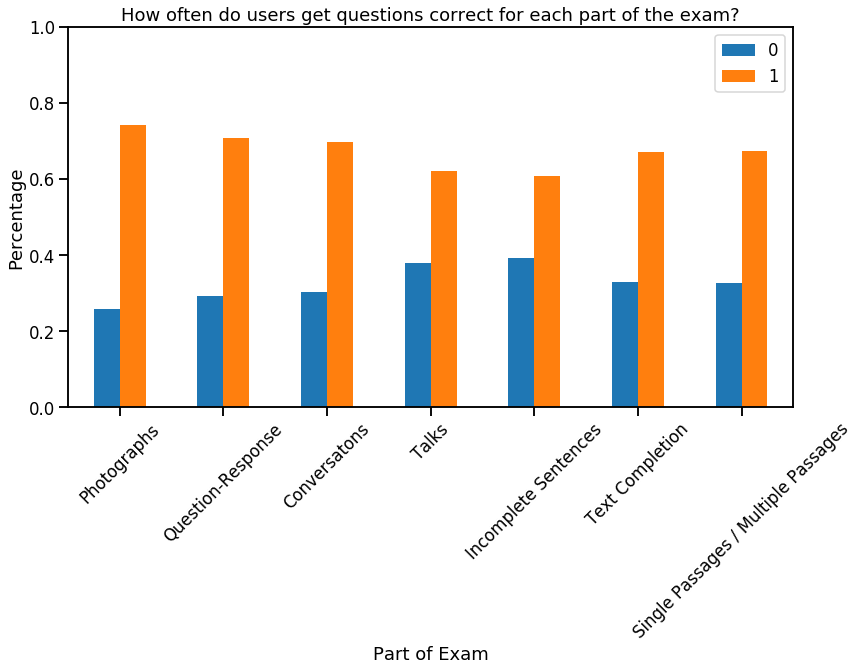

In [173]:
sns.set_context('talk')

pd.crosstab(train.part, train.answered_correctly, normalize='index').plot.bar(figsize=(13, 7))
plt.legend().set_visible(False)
plt.title('How often do users get questions correct for each part of the exam?')
plt.xlabel('Part of Exam')
plt.ylabel('Percentage')

plt.xticks(np.arange(0, 7),
           labels=['Photographs',
                   'Question-Response',
                   'Conversatons',
                   'Talks',
                   'Incomplete Sentences',
                   'Text Completion',
                   'Single Passages / Multiple Passages'],
           rotation=45)

plt.legend()
plt.ylim(0, 1);

## Exponentially Weighted Mean of a users accuracy

In [8]:
user = train.loc[train.user_id == 24600]

In [9]:
user.head()

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,lecture_id,tag,lecture_part,type_of,question_id,bundle_id,correct_answer,question_part,tags
0,0,24600,7900,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,7900.0,7900.0,0.0,1.0,131 93 81
1,25379,24600,7876,0,1,2,0,24000.0,False,NaN,NaN,NaN,NaN,7876.0,7876.0,3.0,1.0,10 94 92
2,50137,24600,175,0,2,2,1,23000.0,False,NaN,NaN,NaN,NaN,175.0,175.0,2.0,1.0,9 10 92
3,70181,24600,1278,0,3,3,1,22000.0,False,NaN,NaN,NaN,NaN,1278.0,1278.0,3.0,2.0,143 140 81 29
4,148601,24600,2064,0,4,2,0,18000.0,False,NaN,NaN,NaN,NaN,2064.0,2063.0,1.0,3.0,157 92 29


In [10]:
# The culmulative total of questions answered correctly by a single user.
user.answered_correctly.cumsum()

0      1
1      1
2      2
3      3
4      3
5      4
6      4
7      4
8      4
9      4
10     4
11     4
12     4
13     4
14     4
15     4
16     4
17     4
18     5
19     5
20     5
21     5
22     5
23     5
24     5
25     5
26     6
27     6
28     6
29     6
30     7
31     8
32     9
33     9
34    10
35    11
36    11
37    11
38    11
39    11
Name: answered_correctly, dtype: int64

In [11]:
# Number of questions a single user has answered
len(user)

40

In [12]:
user.answered_correctly.cumsum()/range(1, len(user.answered_correctly)+1)

0     1.000000
1     0.500000
2     0.666667
3     0.750000
4     0.600000
5     0.666667
6     0.571429
7     0.500000
8     0.444444
9     0.400000
10    0.363636
11    0.333333
12    0.307692
13    0.285714
14    0.266667
15    0.250000
16    0.235294
17    0.222222
18    0.263158
19    0.250000
20    0.238095
21    0.227273
22    0.217391
23    0.208333
24    0.200000
25    0.192308
26    0.222222
27    0.214286
28    0.206897
29    0.200000
30    0.225806
31    0.250000
32    0.272727
33    0.264706
34    0.285714
35    0.305556
36    0.297297
37    0.289474
38    0.282051
39    0.275000
Name: answered_correctly, dtype: float64

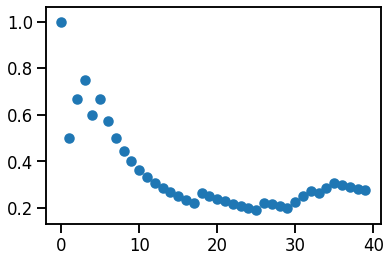

In [13]:
# Calculating the cumulative accuracy of a single user
plt.scatter(x=range(0, len(user.timestamp)),
            y=user.answered_correctly.cumsum()
              / range(1, len(user.answered_correctly)+1))

In [14]:
user.answered_correctly

0     1
1     0
2     1
3     1
4     0
5     1
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    1
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    1
27    0
28    0
29    0
30    1
31    1
32    1
33    0
34    1
35    1
36    0
37    0
38    0
39    0
Name: answered_correctly, dtype: int64

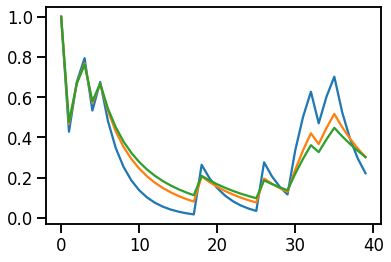

In [15]:
user.answered_correctly.ewm(3).mean().plot()
user.answered_correctly.ewm(7).mean().plot()
user.answered_correctly.ewm(10).mean().plot()

In [176]:
set_user = 0
counter = 0

for index, row in train[:5].iterrows():
    user = row['user_id']
    if set_user == 0:
        current_user = row['user_id']
        counter += 1
    elif user != current_user:
        counter = 0
    elif user == current_user:
        counter += 1
        
print(counter)

5


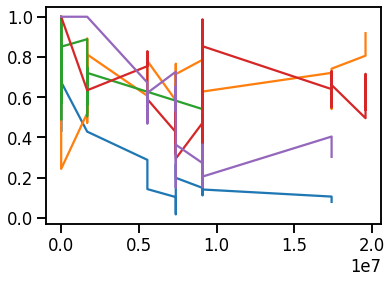

In [185]:
data = pd.DataFrame()

for id_ in train.user_id.unique()[10:15]:
    user_data = train['answered_correctly'].loc[train.user_id == id_]
    id_num = train['user_id'].loc[train.user_id == id_]
    user_ewm = pd.concat([id_num, user_data.ewm(3).mean()], axis=1)
    data = pd.concat([data, user_ewm])

for user in data.user_id.unique():
    data['answered_correctly'].loc[train.user_id == user].plot()

## Check to see the number of unique values in each column

In [20]:
for column in train.columns:
    print(column, train[f'{column}'].nunique())

timestamp 15026308
user_id 100000
content_id 13515
content_type_id 1
task_container_id 9175
user_answer 4
answered_correctly 2
prior_question_elapsed_time 666
prior_question_had_explanation 2
lecture_id 158
tag 105
lecture_part 7
type_of 4
question_id 13515
bundle_id 9762
correct_answer 4
question_part 7
tags 1519


## Correlations between the features and the target variable

In [ ]:
train.corr()['answered_correctly'].sort_values(ascending=False)

# Hypothesis Testing
---
## Hypothesis Test
### Question accuracy is dependent on the type of question asked.

Test: Chi2 Test<br>
$H_0$ Whether a user answers a question correctly is independent of the type of question being asked.<br>
$H_a$ Whether a user answers a question correctly is dependent upon the type of question being asked.

In [ ]:
confidence_interval = 0.95 
alpha = 1 - alpha

# Contingency table
table = pd.crosstab(train_df.answered_correctly, train_df.question_part)
chi2, p, dof, expected = stats.chi2_contingency(table)


if p < alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
    
print(p)

- P is less than alpha so we <strong>reject</strong> the null hypothesis that answering a question correctly is independent of the type of question being asked. (Different parts of the TOEIC exam)

- The 7 parts of the TOEIC exam require the user to answer questions with different formats: Pictures, Listening to conversations, Reading Conversations, Filling in Incomplete Sentences, etc. Depending on which part the user is answering questions...

In [5]:
# Import functions
import pandas as pd
import numpy as np
import math
import os
import acquire
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import random
random.seed(123)

import prepare
import explore

In [2]:
train = pd.read_csv('sampled_trainset.csv')
validate = pd.read_csv('validate.csv')
test = pd.read_csv('test.csv')

In [6]:
train, validate, test, train_s, validate_s, test_s = prepare.prep_riiid(train, validate, test)

In [7]:
train.head()

,timestamp,user_id,content_id,task_container_id,answered_correctly,question_had_explanation,user_acc_mean,user_lectures_running_total,q_time,avg_user_q_time,...,part,tags,tag_count,mean_bundle_accuracy,mean_part_accuracy,mean_container_part_accuracy,mean_content_accuracy,mean_task_accuracy,mean_tagcount_accuracy,mean_tags_accuracy
0,0,24600,7900,0,1,False,0.275000,0,25379.0,70525.0,...,1,131 93 81,3,0.82,0.74,0.82,0.82,0.68,0.68,0.78
1,25379,24600,7876,1,0,False,0.275000,0,24758.0,70525.0,...,1,10 94 92,3,0.41,0.74,0.39,0.41,0.53,0.68,0.49
2,50137,24600,175,2,1,False,0.275000,0,20044.0,70525.0,...,1,9 10 92,3,0.36,0.74,0.34,0.36,0.44,0.68,0.52
3,0,128919,7900,0,1,False,0.333333,0,22862.0,60393.0,...,1,131 93 81,3,0.82,0.74,0.82,0.82,0.68,0.68,0.78
4,22862,128919,7876,1,0,False,0.333333,0,24620.0,60393.0,...,1,10 94 92,3,0.41,0.74,0.39,0.41,0.53,0.68,0.49


# Visualizations

In [8]:
train = train.assign(
        is_reading = np.where(train.part > 4, 'Reading', 'Listening'),
        is_incomplete_sentence_part = np.where(train.part == 5, 'incomplete sentences', 'other')
)

## `bundle_id`

In [9]:
# Select features to create bundle_id visualizations.
bundle_data = train[['part', 'mean_bundle_accuracy', 'answered_correctly']].copy()

# Display the first 5 rows of the subset.
bundle_data.head()

,part,mean_bundle_accuracy,answered_correctly
0,1,0.82,1
1,1,0.41,0
2,1,0.36,1
3,1,0.82,1
4,1,0.41,0


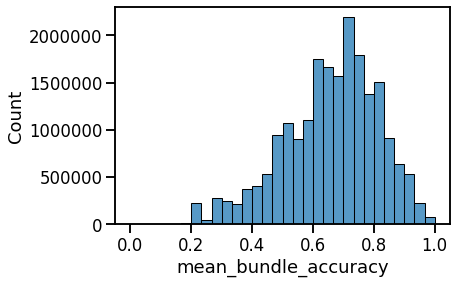

In [10]:
sns.set_context('talk')

sns.histplot(data=bundle_data, x='mean_bundle_accuracy', bins=30)

In [11]:
bundle_data = bundle_data.assign(
        is_reading = np.where(bundle_data.part > 4, 'Reading', 'Listening')
)

bundle_data.head()

,part,mean_bundle_accuracy,answered_correctly,is_reading
0,1,0.82,1,Listening
1,1,0.41,0,Listening
2,1,0.36,1,Listening
3,1,0.82,1,Listening
4,1,0.41,0,Listening


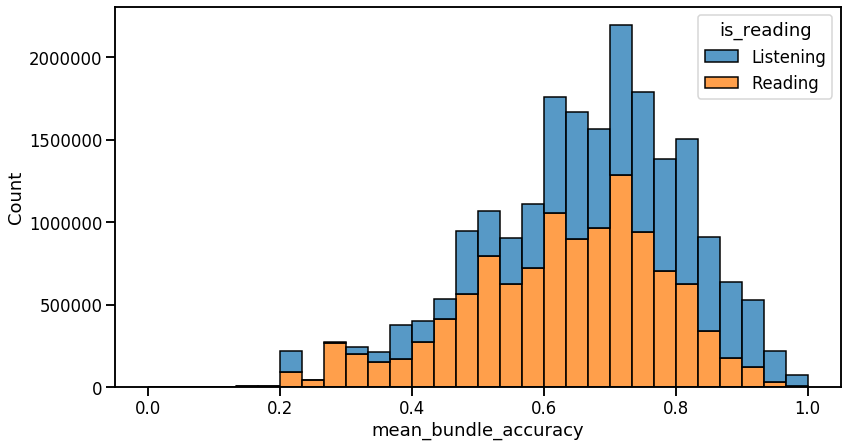

In [13]:
sns.set_context('talk')
plt.figure(figsize=(13, 7))

sns.histplot(data=bundle_data, x='mean_bundle_accuracy', hue='is_reading', bins=30, multiple="stack");

In [14]:
listening = bundle_data.loc[bundle_data['is_reading'] == 'Listening']
reading = bundle_data.loc[bundle_data['is_reading'] == 'Reading']

confidence_interval = .95
alpha = 1 - confidence_interval

t, p = stats.ttest_ind(listening.mean_bundle_accuracy, reading.mean_bundle_accuracy)

if p < alpha:
    print('Reject H0')
else:
    print('Fail to reject H0')
    
print(t, p)

Reject H0
1036.2467633345902 0.0


In [15]:
bundle_data.part.value_counts()

5    8303034
2    3873071
6    2182718
3    1827478
4    1719610
1    1673007
7     975601
Name: part, dtype: int64

In [16]:
bundle_data = bundle_data.assign(
    is_incomplete_sentence_section = np.where(bundle_data.part == 5, True, False)
)

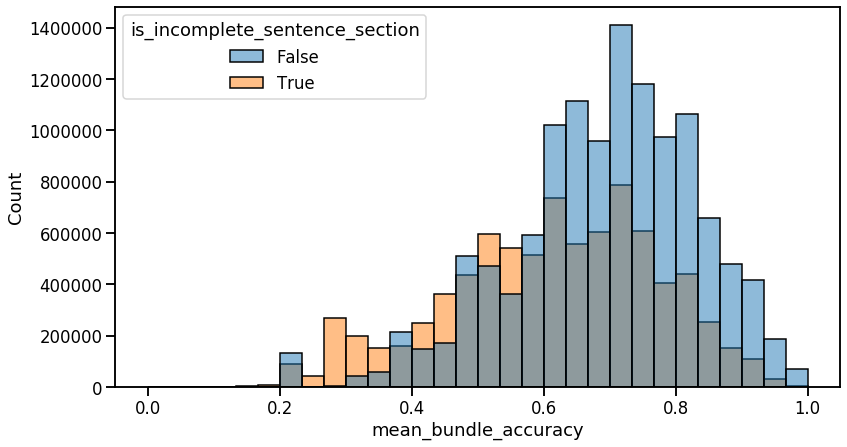

In [17]:
sns.set_context('talk')
plt.figure(figsize=(13, 7))

sns.histplot(data=bundle_data, x='mean_bundle_accuracy', hue='is_incomplete_sentence_section', bins=30);

In [18]:
part_5 = bundle_data.loc[bundle_data['is_incomplete_sentence_section'] == 1]
other_parts = bundle_data.loc[bundle_data['is_incomplete_sentence_section'] == 0]

print(part_5.mean_bundle_accuracy.var())
print(other_parts.mean_bundle_accuracy.var())

0.025961719465522896
0.02012792762088904


In [19]:
confidence_interval = .95
alpha = 1 - confidence_interval

t, p = stats.ttest_ind(part_5.mean_bundle_accuracy, other_parts.mean_bundle_accuracy)

if p < alpha:
    print('Reject H0')
else:
    print('Fail to reject H0')
    
print(t, p)

Reject H0
-1200.4171873067112 0.0


## `mean_container_part_accuracy`

How does a container relate to a bundle and or a question?
- Create a table
- Generate a visual to explain how each column relates to the others.

In [24]:
# Select features to create container part visualizations.
container_part_data = train[['part',
                             'question_id',
                             'question_had_explanation',
                             'mean_container_part_accuracy',
                             'answered_correctly',
                             'is_reading',
                             'is_incomplete_sentence_part',
                             'task_container_id']].copy()

In [25]:
print(container_part_data.shape)
container_part_data.head()

(20554519, 8)


,part,question_id,question_had_explanation,mean_container_part_accuracy,answered_correctly,is_reading,is_incomplete_sentence_part,task_container_id
0,1,7900,False,0.82,1,Listening,other,0
1,1,7876,False,0.39,0,Listening,other,1
2,1,175,False,0.34,1,Listening,other,2
3,1,7900,False,0.82,1,Listening,other,0
4,1,7876,False,0.39,0,Listening,other,1


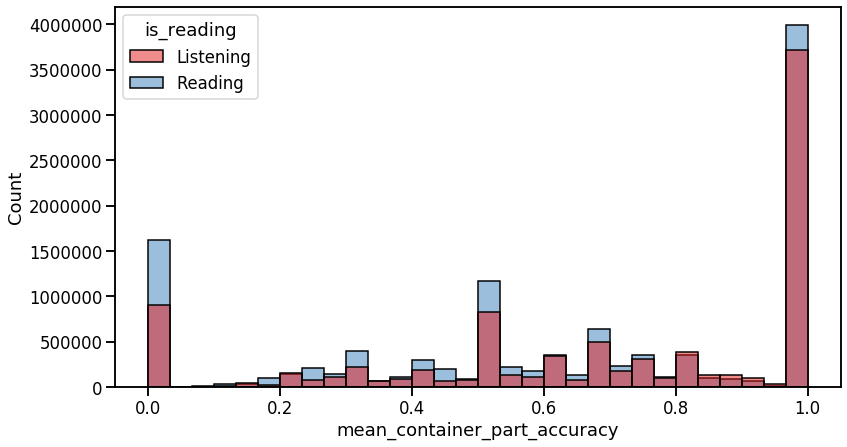

In [120]:
sns.set_context('talk')
plt.figure(figsize=(13, 7))

sns.histplot(data=container_part_data,
             x='mean_container_part_accuracy',
             hue='is_reading',
             palette='Set1',
             bins=30);

In [ ]:
sns.set_context('talk')
plt.figure(figsize=(13, 7))

sns.histplot(data=container_part_data,
             x='mean_container_part_accuracy',
             hue='is_reading',
             palette='Set1',
             bins=30);

In [28]:
container_had_explanation = container_part_data.loc[container_part_data.question_had_explanation == True]
container_without_explanation = container_part_data.loc[container_part_data.question_had_explanation == False]

stats.levene(container_had_explanation.mean_container_part_accuracy,
             container_without_explanation.mean_container_part_accuracy)

LeveneResult(statistic=287940.55967839627, pvalue=0.0)

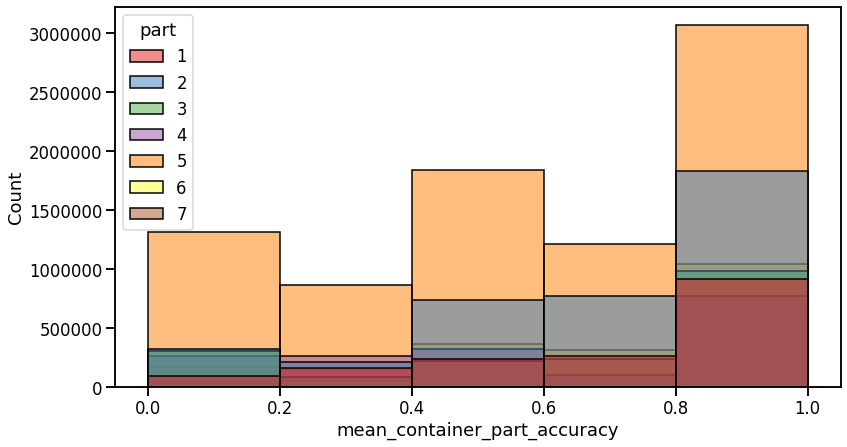

In [29]:
sns.set_context('talk')
plt.figure(figsize=(13, 7))

sns.histplot(data=container_part_data,
             x='mean_container_part_accuracy',
             hue='part',
             palette='Set1',
             bins=5);

In [30]:
container_part_data.task_container_id.nunique()

9175

In [125]:
train[20:40]

,timestamp,user_id,content_id,task_container_id,answered_correctly,question_had_explanation,user_acc_mean,user_lectures_running_total,q_time,avg_user_q_time,...,tag_count,mean_bundle_accuracy,mean_part_accuracy,mean_container_part_accuracy,mean_content_accuracy,mean_task_accuracy,mean_tagcount_accuracy,mean_tags_accuracy,is_reading,is_incomplete_sentence_part
20,2457779502,275762,56,21,1,True,0.764933,0,56739.0,11286048.0,...,4,0.72,0.74,0.68,0.72,0.62,0.70,0.78,Listening,other
21,2457836241,275762,7972,22,1,True,0.764933,0,46203.0,11286048.0,...,3,0.71,0.74,0.58,0.71,0.62,0.68,0.82,Listening,other
22,2457882444,275762,10573,23,1,True,0.764933,0,37427.0,11286048.0,...,3,0.81,0.74,0.71,0.81,0.61,0.68,0.86,Listening,other
23,2457919871,275762,7863,24,1,True,0.764933,0,72239.0,11286048.0,...,3,0.90,0.74,0.91,0.90,0.63,0.68,0.89,Listening,other
24,2457992110,275762,86,25,0,True,0.764933,0,119703.0,11286048.0,...,3,0.74,0.74,0.80,0.74,0.62,0.68,0.83,Listening,other
25,2458111813,275762,7916,26,0,True,0.764933,0,67231.0,11286048.0,...,4,0.85,0.74,0.85,0.85,0.61,0.70,0.86,Listening,other
26,2458179044,275762,10479,27,1,True,0.764933,0,100295.0,11286048.0,...,3,0.88,0.74,1.00,0.88,0.62,0.68,0.87,Listening,other
27,2458279339,275762,110,28,1,True,0.764933,0,112735.0,11286048.0,...,3,0.62,0.74,0.52,0.62,0.62,0.68,0.68,Listening,other
28,2458392074,275762,7974,29,1,True,0.764933,0,91845.0,11286048.0,...,3,0.71,0.74,0.73,0.71,0.62,0.68,0.75,Listening,other
29,2458483919,275762,2,30,1,True,0.764933,0,151133.0,11286048.0,...,4,0.55,0.74,0.50,0.55,0.64,0.70,0.55,Listening,other


In [100]:
data = train.groupby(['part', 'bundle_id', 'task_container_id'])['user_id'].agg(['count']).round(2).reset_index()

In [122]:
train.groupby(by=['task_container_id', 'bundle_id', 'part'])['answered_correctly']
            .agg(['count', 'mean'])\
            .reset_index()\
            .sort_values(by='count', ascending=False)

,task_container_id,bundle_id,part,count,mean
14435,4,2063,3,114055,0.461821
17657,5,3363,4,113277,0.362536
20972,6,2946,4,109706,0.214619
25030,7,2593,4,108954,0.481488
77775,15,7216,7,79232,0.480841
...,...,...,...,...,...
4277232,1078,4841,5,1,0.000000
4277233,1078,4844,5,1,0.000000
1486972,255,4593,5,1,0.000000
4277235,1078,4855,5,1,1.000000


In [119]:
sum(train.loc[train.user_id == 455973631].task_container_id.value_counts() > 5)

0

In [ ]:
part_container_data = train.groupby(['part', 'task_container_id', 'bundle_id']).size().reset_index()

In [ ]:
part_container_data.loc[part_container_data.part == 1]

In [ ]:
part_container_data.loc[part_container_data.part == 2]

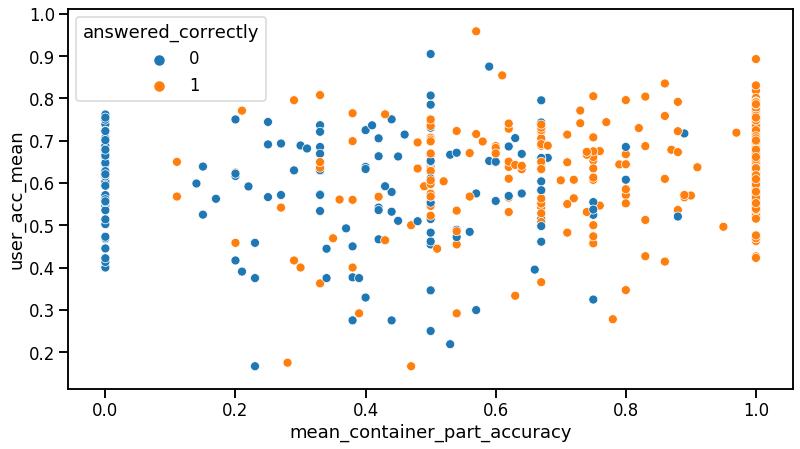

In [158]:
sampled_data = train.sample(500)

sns.set_context('talk')
plt.figure(figsize=(13, 7))
sns.scatterplot(sampled_data.mean_container_part_accuracy,
                sampled_data.user_acc_mean,
                hue=sampled_data.answered_correctly)

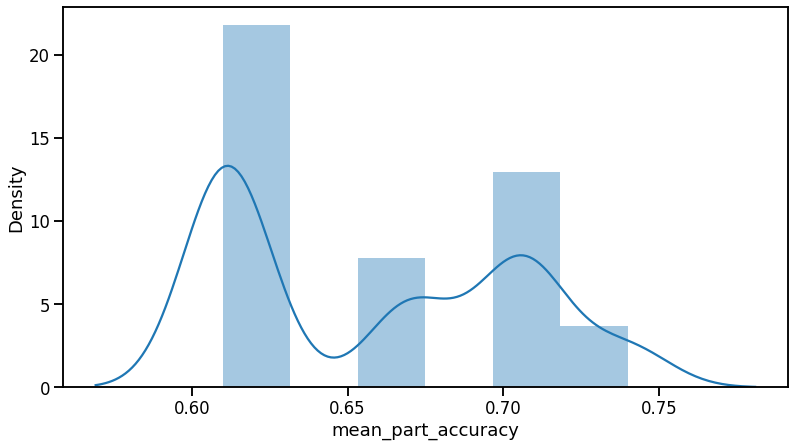

In [186]:
sampled_data = train.sample(500)

sns.set_context('talk')
plt.figure(figsize=(13, 7))
sns.distplot(sampled_data.mean_part_accuracy)

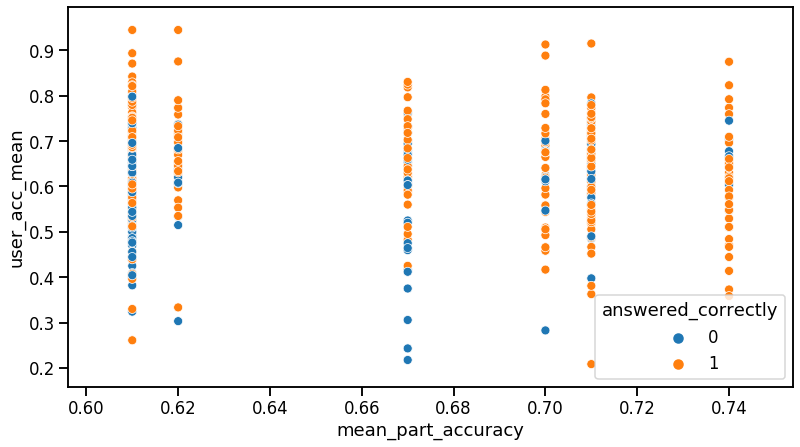

In [187]:
sampled_data = train.sample(500)

sns.set_context('talk')
plt.figure(figsize=(13, 7))
sns.scatterplot(sampled_data.mean_part_accuracy,
                sampled_data.user_acc_mean,
                hue=sampled_data.answered_correctly)

In [188]:
train.head()

,timestamp,user_id,content_id,task_container_id,answered_correctly,question_had_explanation,user_acc_mean,user_lectures_running_total,q_time,avg_user_q_time,...,tag_count,mean_bundle_accuracy,mean_part_accuracy,mean_container_part_accuracy,mean_content_accuracy,mean_task_accuracy,mean_tagcount_accuracy,mean_tags_accuracy,is_reading,is_incomplete_sentence_part
0,0,24600,7900,0,1,False,0.275000,0,25379.0,70525.0,...,3,0.82,0.74,0.82,0.82,0.68,0.68,0.78,Listening,other
1,25379,24600,7876,1,0,False,0.275000,0,24758.0,70525.0,...,3,0.41,0.74,0.39,0.41,0.53,0.68,0.49,Listening,other
2,50137,24600,175,2,1,False,0.275000,0,20044.0,70525.0,...,3,0.36,0.74,0.34,0.36,0.44,0.68,0.52,Listening,other
3,0,128919,7900,0,1,False,0.333333,0,22862.0,60393.0,...,3,0.82,0.74,0.82,0.82,0.68,0.68,0.78,Listening,other
4,22862,128919,7876,1,0,False,0.333333,0,24620.0,60393.0,...,3,0.41,0.74,0.39,0.41,0.53,0.68,0.49,Listening,other


In [249]:
table = pd.crosstab(pd.cut(train.q_time, bins=4), train.part)

confidence_interval = 0.95 
alpha = 1 - alpha

# Contingency table
chi2, p, dof, expected = stats.chi2_contingency(table)


if p < alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
    
print(chi2, round(p, 4))

Dependent (reject H0)
991.1541856939164 0.0


In [221]:
table = pd.crosstab(pd.cut(train.task_container_id, bins=4), train.answered_correctly)

confidence_interval = 0.95 
alpha = 1 - alpha

# Contingency table
chi2, p, dof, expected = stats.chi2_contingency(table)


if p < alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
    
print(chi2, round(p, 4))

Dependent (reject H0)
21301.643996069153 0.0


In [222]:
table

answered_correctly,0,1
task_container_id,,
"(-9.176, 2294.0]",6564563,12339939
"(2294.0, 4588.0]",373327,886536
"(4588.0, 6882.0]",87593,226370
"(6882.0, 9176.0]",20427,55764


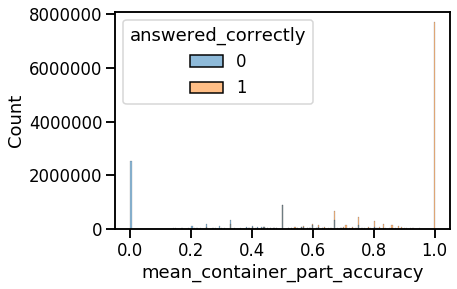

In [230]:
sns.histplot(data=train,
             x="mean_container_part_accuracy",
             hue="answered_correctly")

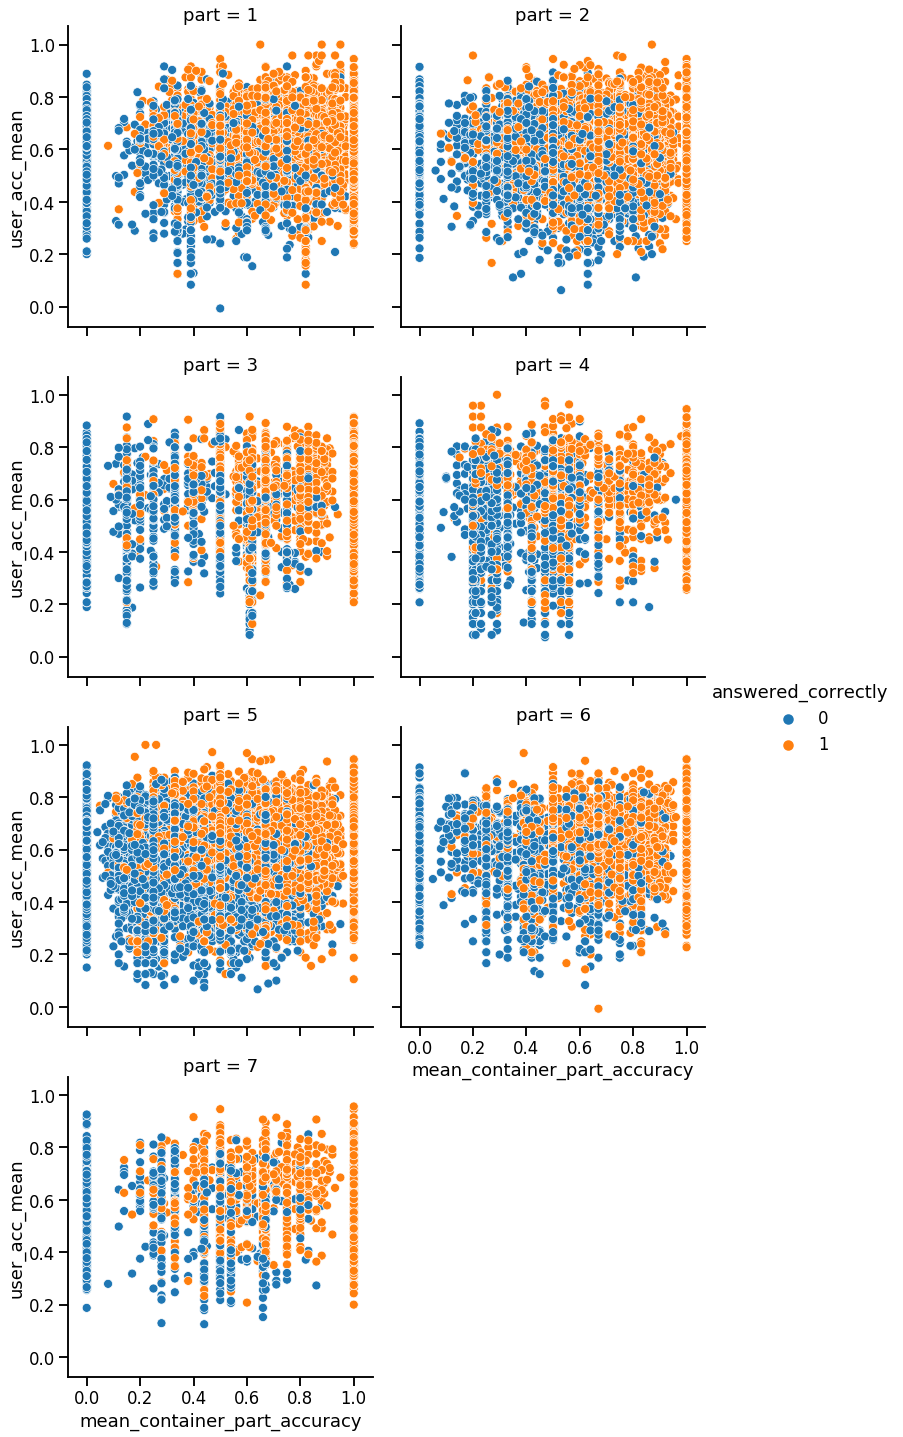

In [257]:
sns.set_context('talk')

sns.relplot(
    data=train.sample(100_000),
    x="mean_container_part_accuracy",
    y='user_acc_mean',
    hue='answered_correctly',
    col='part',
    col_wrap=2
)

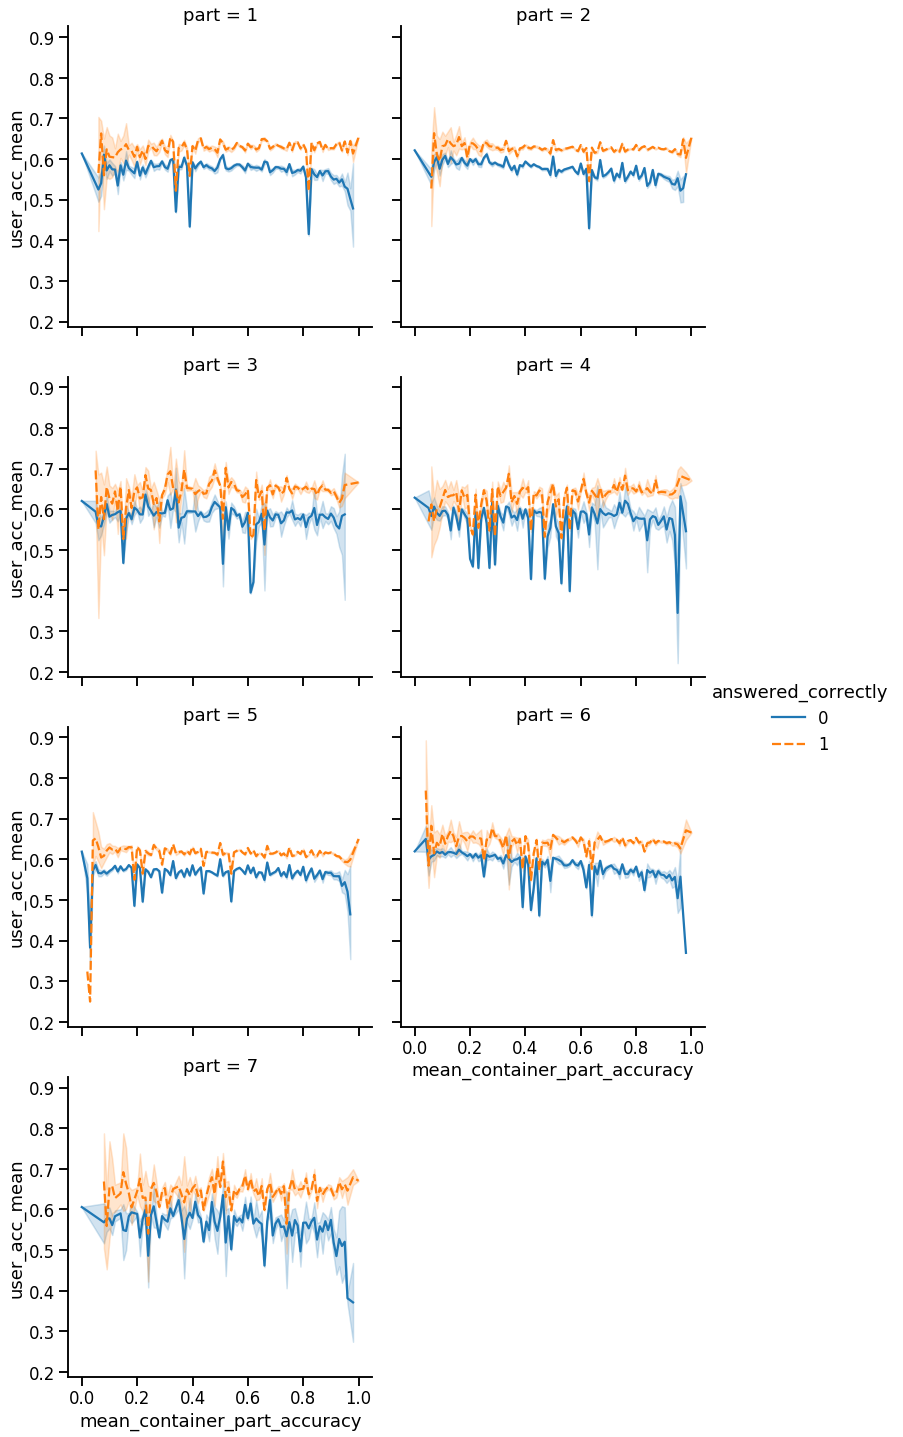

In [268]:
sns.relplot(data=train,
            x="mean_container_part_accuracy",
            y="user_acc_mean",
            col="part",
            col_wrap=2,
            hue="answered_correctly",
            style="answered_correctly",
            kind="line"
)

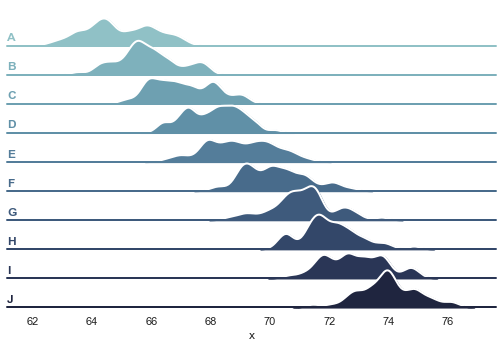

In [269]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data
rs = np.random.RandomState(1979)
x = rs.randn(500)
g = np.tile(list("ABCDEFGHIJ"), 50)
df = pd.DataFrame(dict(x=x, g=g))
m = df.g.map(ord)
df["x"] += m

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "x",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=.5)
g.map(plt.axhline, y=0, lw=2, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "x")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)